Order_Demand    0
dtype: int64
int64
Epoch 1/200
97/97 - 2s - loss: 0.8795 - 2s/epoch - 22ms/step
Epoch 2/200
97/97 - 0s - loss: 0.8747 - 405ms/epoch - 4ms/step
Epoch 3/200
97/97 - 0s - loss: 0.8725 - 463ms/epoch - 5ms/step
Epoch 4/200
97/97 - 0s - loss: 0.8699 - 470ms/epoch - 5ms/step
Epoch 5/200
97/97 - 0s - loss: 0.8690 - 405ms/epoch - 4ms/step
Epoch 6/200
97/97 - 0s - loss: 0.8703 - 404ms/epoch - 4ms/step
Epoch 7/200
97/97 - 0s - loss: 0.8683 - 405ms/epoch - 4ms/step
Epoch 8/200
97/97 - 0s - loss: 0.8677 - 399ms/epoch - 4ms/step
Epoch 9/200
97/97 - 0s - loss: 0.8661 - 417ms/epoch - 4ms/step
Epoch 10/200
97/97 - 0s - loss: 0.8675 - 419ms/epoch - 4ms/step
Epoch 11/200
97/97 - 0s - loss: 0.8658 - 407ms/epoch - 4ms/step
Epoch 12/200
97/97 - 0s - loss: 0.8648 - 413ms/epoch - 4ms/step
Epoch 13/200
97/97 - 0s - loss: 0.8615 - 419ms/epoch - 4ms/step
Epoch 14/200
97/97 - 0s - loss: 0.8587 - 408ms/epoch - 4ms/step
Epoch 15/200
97/97 - 1s - loss: 0.8575 - 543ms/epoch - 6ms/step
Epoch 16/200
9

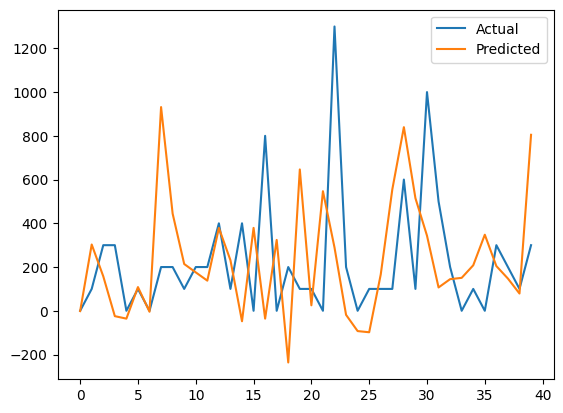

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Load dữ liệu
data = pd.read_csv('/content/drive/MyDrive/Book2.csv')

df = pd.DataFrame(data)

# Chuyển cột 'Date' sang định dạng datetime
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

# Đặt cột 'Date' làm chỉ số cho DataFrame
df.set_index('Date', inplace=True)
# Kiểm tra giá trị thiếu
print(df.isnull().sum())
print(df['Order_Demand'].dtype)
if df['Order_Demand'].dtype != 'O':
    df['Order_Demand'] = df['Order_Demand'].astype(str)
# Xử lý cột 'Order_Demand' để loại bỏ các ký tự không phải số
df['Order_Demand'] = pd.to_numeric(df['Order_Demand'].str.replace(r'[^0-9-]', '', regex=True), errors='coerce')
df = df.resample('W').sum()

# Welford algorithm
def update_welford(mean, var, count, new_value):
    count += 1
    delta = new_value - mean
    mean += delta / count
    delta2 = new_value - mean
    var += delta * delta2
    return mean, var, count

# Tính mean và std bằng Welford algorithm
count = 0
mean = 0
var = 0
for value in df['Order_Demand']:
    mean, var, count = update_welford(mean, var, count, value)

std = np.sqrt(var / count)

# Chuẩn hóa dữ liệu
df['Order_Demand'] = (df['Order_Demand'] - mean) / std



# univariate lstm example
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train_size = int(len(df) * 0.8)
train, test = df['Order_Demand'][:train_size], df['Order_Demand'][train_size:]

# Hàm tạo dataset cho mô hình LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        X.append(a)
        Y.append(dataset[i + look_back])
    return np.array(X), np.array(Y)

# Tạo dataset cho mô hình với look_back
look_back = 12
X_train, y_train = create_dataset(train.values, look_back)
X_test, y_test = create_dataset(test.values, look_back)

# Reshape input để đảm bảo phù hợp với đầu vào của mô hình LSTM (số mẫu, số bước thời gian, số đặc trưng)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=200, batch_size=2, verbose=2)

# Dự báo trên tập kiểm tra
y_pred = model.predict(X_test)

# Đảo ngược quá trình chuẩn hóa Z-score
y_pred_inv = (y_pred * std) + mean
y_test_inv = (y_test * std) + mean

# Tính RMSE
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print('Root Mean Squared Error (RMSE):', rmse)

# Hiển thị dự báo và thực tế trên biểu đồ
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.legend()
plt.show()


In [ ]:
# Tính MAPE
from sklearn.metrics import mean_absolute_error
mape = mean_absolute_error(y_test_inv, y_pred_inv[:, 0]) / np.mean(y_test_inv) * 100
print('Mean Absolute Percentage Error (MAPE):', mape)




Mean Absolute Percentage Error (MAPE): 119.12674331665039
